In [1]:
import pandas as pd
from sodapy import Socrata
import os
import matplotlib.pyplot as plt
import numpy as np
import re

HATECRIME_DATA_FILENAME = r"data\hatecrime_opennyc.csv"
# if the file not exists, request the data from nyc open data.
if not os.path.exists(HATECRIME_DATA_FILENAME):
    client = Socrata("data.cityofnewyork.us", None)

    # there is only 3575, so I set limit=4000 to get all the data from it.
    results = client.get("bqiq-cu78", limit=4000)

    # Convert to pandas DataFrame
    results_df = pd.DataFrame.from_records(results)
    results_df.to_csv(HATECRIME_DATA_FILENAME, index = False)

# read data from csv file.
df = pd.read_csv(HATECRIME_DATA_FILENAME)

# remove some useless prefix in the data set. contains data for [2019, 2020, 2021, 2022, 2023, 2024, 2025]
df["patrol_borough_name"] = df["patrol_borough_name"].apply(lambda x: x.replace("PATROL BORO ", ""))

# remove 2025, since it is not end, the data is not accurate.
df = df[df["complaint_year_number"] != 2025]

In [2]:
by_year_region = df.groupby(["complaint_year_number","patrol_borough_name"])["full_complaint_id"].count().unstack(level="patrol_borough_name")
# currently the columns name is patrol_borough_name. We don't need it so just remove it
by_year_region.columns.name = None
# calculate total
by_year_region.loc['total'] = by_year_region.sum()
# rename columns
# Rename columns for readability
by_year_region.rename(columns={
    "BKLYN NORTH": "Brooklyn North",
    "BKLYN SOUTH": "Brooklyn South",
    "BRONX": "Bronx",
    "MAN NORTH": "Manhattan North",
    "MAN SOUTH": "Manhattan South",
    "QUEENS NORTH": "Queens North",
    "QUEENS SOUTH": "Queens South",
    "STATEN ISLAND": "Staten Island"
}, inplace=True)
by_year_region.to_csv("nyc_hate_crime_by_year_region.csv")
by_year_region

,Brooklyn North,Brooklyn South,Bronx,Manhattan North,Manhattan South,Queens North,Queens South,Staten Island
complaint_year_number,,,,,,,,
2019,87,103,33,56,82,51,25,10
2020,50,55,26,34,52,27,22,18
2021,62,90,49,78,165,77,38,21
2022,116,131,43,88,168,63,35,28
2023,108,136,30,133,162,99,64,26
2024,101,157,24,115,159,85,44,24
total,524,672,205,504,788,402,228,127


In [3]:
# analysis part.
by_year = df.groupby(["complaint_year_number","bias_motive_description"])["full_complaint_id"].count().unstack("bias_motive_description")
# after fillna(0), the output of the table content become float number. use astype to parse them back to int.
by_year = by_year[["ANTI-ASIAN","ANTI-BLACK","ANTI-MALE HOMOSEXUAL (GAY)","ANTI-JEWISH"]]
# remove columns name
by_year.columns.name = None
by_year = by_year.fillna(0).astype(int)
by_year.to_csv("hate_crime_bias_motive_description_by_year.csv")
by_year

,ANTI-ASIAN,ANTI-BLACK,ANTI-MALE HOMOSEXUAL (GAY),ANTI-JEWISH
complaint_year_number,,,,
2019,1,37,52,252
2020,33,36,29,126
2021,150,41,78,215
2022,91,56,85,279
2023,60,56,116,343
2024,42,42,86,370


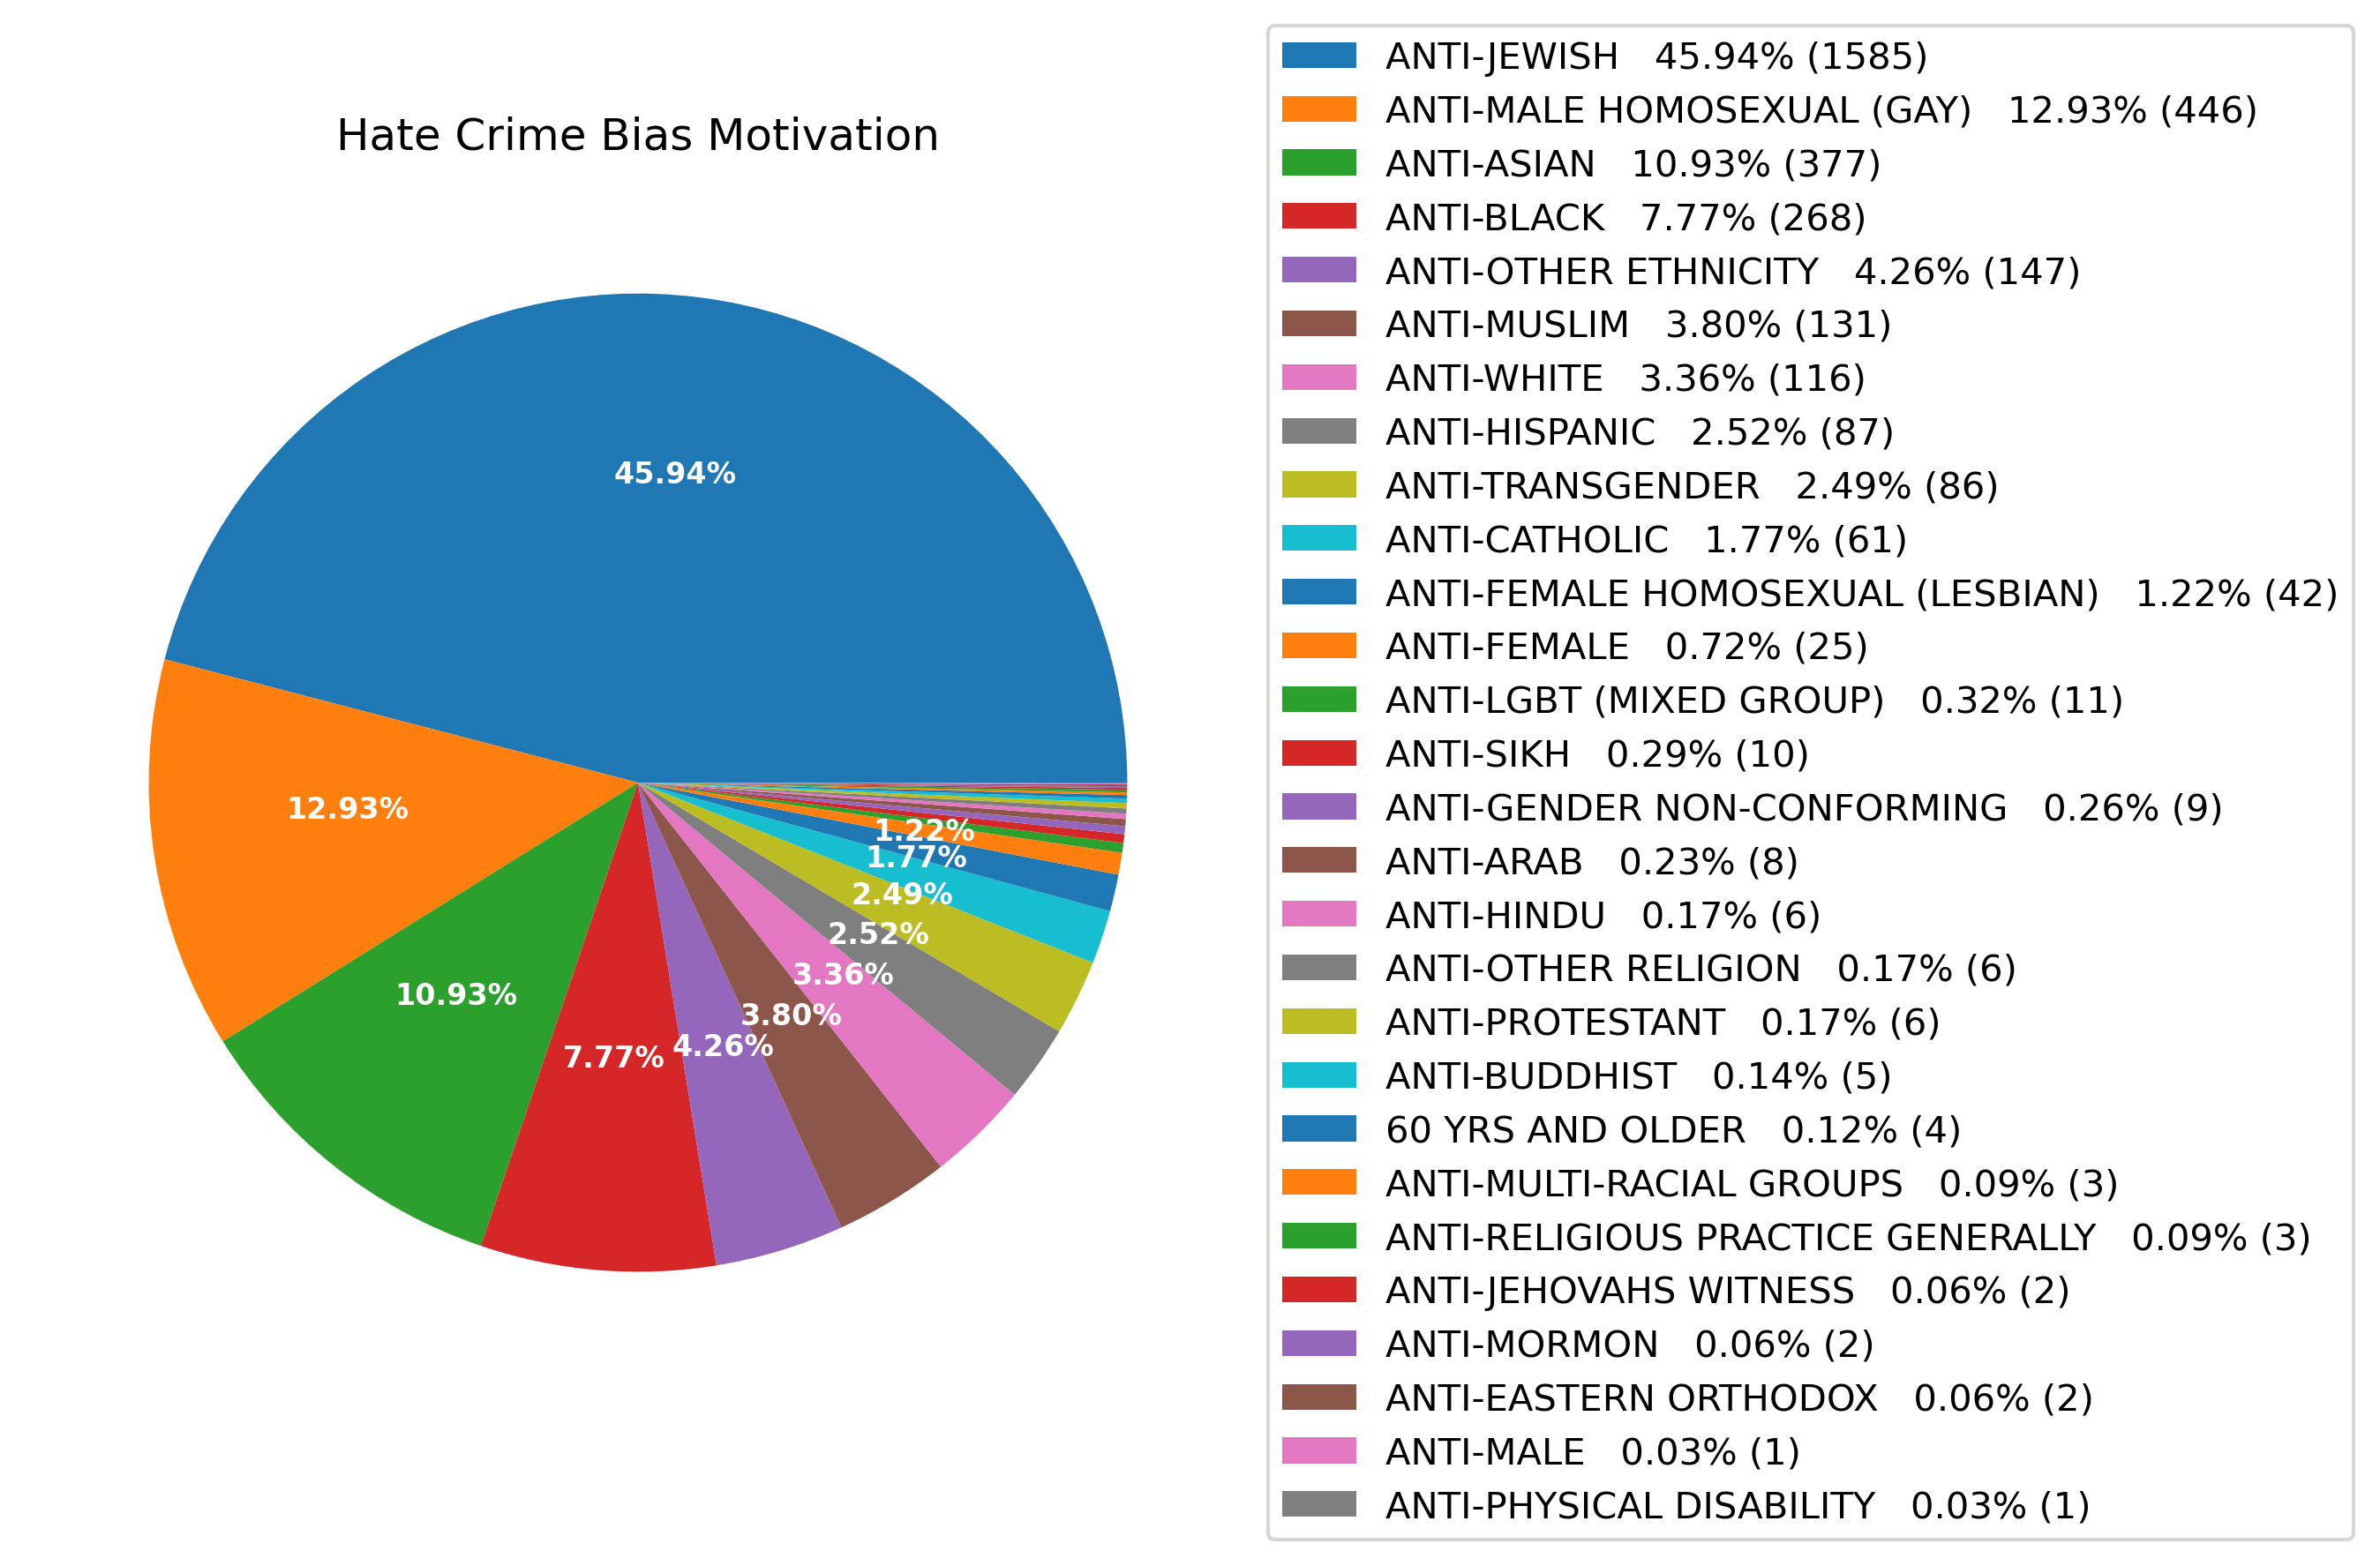

In [4]:
# draw a pie graph. I use some package not in our class(but actually it was used by pandas, so it is somehow, part of our class). 
# So I can draw a more, beauitiful pie grpah.
# here is the link(where I copy these code)
# https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
def drawBiasMotivation(s):
    fig, ax = plt.subplots(figsize=(18, 6), dpi= 300, subplot_kw=dict(aspect="equal"))
    data = s.values
    labels = s.index
    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: f"{pct:.2f}%\n" if pct > 1 else "", textprops=dict(color="w"))

    ax.legend(wedges, 
              [f"{label}   {(count / s.sum()) * 100:.2f}% ({count})"for count, label in zip(data, labels)],
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")

    ax.set_title("Hate Crime Bias Motivation")
    plt.show()
drawBiasMotivation(df.value_counts("bias_motive_description"))

In [5]:
# index is the year, sort_index is sort the value by index, [:-1] is written to remove the data of 2025. Which is useless.
# number of nyc anti-jewish each year.
anti_jewish = df[df['bias_motive_description'] == "ANTI-JEWISH"]['complaint_year_number'].value_counts().sort_index()[:-1]
# number of nyc hate crime each year.
hate_crime = df['complaint_year_number'].value_counts().sort_index()[:-1]

# use lambda as a variable, very easy to understand I guess.
parse_pct = lambda x: (f"{x * 100:.2f}%" if not pd.isna(x) else "NA")
# get percent change data of both hate crime total incidents and anti-jewish inicdents.
hate_crime_change = hate_crime.pct_change().apply(parse_pct)
anti_jewish_change = anti_jewish.pct_change().apply(parse_pct)
con = pd.concat([hate_crime_change,anti_jewish_change],axis=1)

# change column names.
con.columns = ["Hate Crime Incidents Change","ANTI-Jewish Hate Crime Incidents Change"]
# write to csv files.
con.to_csv("hate_crime_and_anti_jewish_yearly_change.csv")
# set index name to none would looks better.
con.index.name = None
con

,Hate Crime Incidents Change,ANTI-Jewish Hate Crime Incidents Change
2019,NA,NA
2020,-36.47%,-50.00%
2021,104.23%,70.63%
2022,15.86%,29.77%
2023,12.80%,22.94%


In [6]:
number_of_nyc_hate_crime_2023 = hate_crime[2023]
hate_crime

complaint_year_number
2019    447
2020    284
2021    580
2022    672
2023    758
Name: count, dtype: int64

In [7]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt

HATE_CRIME_BIAS_TYPE2023 = r"data\hate_crime_bias_type_2023.xlsx"

# if file doesn't exist, get the data from url, write it into a file
if not os.path.exists(HATE_CRIME_BIAS_TYPE2023):
    res = requests.get("https://www.criminaljustice.ny.gov/crimnet/ojsa/hatecrimesbiastype2023.xlsx")
    # write + binary mode
    with open(HATE_CRIME_BIAS_TYPE2023, "wb") as f:
        f.write(res.content)

# read the file we downloaded.
df = pd.read_excel(HATE_CRIME_BIAS_TYPE2023)

# get the row which contains the data of total_incidents.
total_incidents_row = df.iloc[4]

# get the row which contains the data of anti_jewish incidents.
anti_jewish_row = df.iloc[9]

# list of years which was included in the data.
year_list = ["2019", "2020", "2021", "2022", "2023"]


def get_year_region_df(s):
    # only keep those numbers.
    s = s[2:]
    nystate = [s.iloc[i] for i in range(len(year_list))]
    nyc = [s.iloc[i + 5] for i in range(len(year_list))]
    non_nyc = [s.iloc[i + 10] for i in range(len(year_list))]
    df = pd.DataFrame({
        # "NYState":nystate,
        "NYC": nyc,
        "Non-NYC": non_nyc
    })
    df.index = year_list
    # df.drop("2023", inplace=True)  # drop 2023 since there are NaN data.
    return df
total_incidents_df = get_year_region_df(total_incidents_row)
total_incidents_df

,NYC,Non-NYC
2019,420.0,224.0
2020,272.0,233.0
2021,514.0,278.0
2022,594.0,372.0
2023,NaN,420.0


In [8]:
non_nyc_hate_crime_2023 = int(total_incidents_df.loc["2023", "Non-NYC"])
non_nyc_hate_crime_2023

420

In [9]:
import os

import sodapy
import pandas as pd

HATE_CRIME_BY_COUNTY_BIAS_BEGINNING_2010 = r"data\hatecrime_by_county.csv"

# doesn't exist, use Socrata to get the data
if not os.path.exists(HATE_CRIME_BY_COUNTY_BIAS_BEGINNING_2010):
    client = sodapy.Socrata("data.ny.gov", app_token=None)
    res = client.get("6xda-q7ev", limit=1000)
    res_df = pd.DataFrame.from_records(res)
    res_df.to_csv(HATE_CRIME_BY_COUNTY_BIAS_BEGINNING_2010, index=False)

# read the data from csv
df = pd.read_csv(HATE_CRIME_BY_COUNTY_BIAS_BEGINNING_2010)
# those county located in New York State
nyc_county_list = ["Bronx", "Kings", "New York", "Queens", "Richmond"]
# set incidents type to int. If we don't do this step, the output will be 350.0(float). Doesn't look good.
df["total_incidents"] = df["total_incidents"].astype(int)
s1 = df[df["county"].isin(nyc_county_list)].groupby("year")[["total_incidents"]].sum()
s2 = df[~ df["county"].isin(nyc_county_list)].groupby("year")[["total_incidents"]].sum()
hate_crimes_nyc_ros = pd.concat([s1, s2], axis=1, ignore_index=True)
hate_crimes_nyc_ros = hate_crimes_nyc_ros.rename(columns={0: "New York City", 1: "Rest of State"})
hate_crimes_nyc_ros.loc[2023] = [number_of_nyc_hate_crime_2023, non_nyc_hate_crime_2023]
hate_crimes_nyc_ros.to_excel("beginning2010.xlsx")
hate_crimes_nyc_ros

,New York City,Rest of State
year,,
2010,350,353
2011,242,314
2012,376,359
2013,315,302
2014,308,250
2015,307,196
2016,370,230
2017,323,237
2018,352,175


In [10]:
sub = hate_crimes_nyc_ros.loc[[2022, 2023]]
total_2022_2023_nyc_df = sub["New York City"] + sub["Rest of State"]
total_2022_2023_nyc_df

year
2022     958
2023    1178
dtype: int64

In [11]:
# this code scrawl from the web page. Aim to get the crime data of NY state hate crime data.
# to understand this code you should go the webpage of this url and inspect the webpage.
from bs4 import BeautifulSoup
import requests
res = requests.get("https://www.justice.gov/hatecrimes/state-data/new-york")
bs = BeautifulSoup(res.content,"html.parser")
# find the first table. The Bias Motivation Cateogry by Year table.
rows = bs.find("table").find_all("tr")
# the first element is "Bias Movivation Category" should ignore.
columns = [p.text for p in rows[0]][1:] 
df = pd.DataFrame(columns = [int(c) for c in columns])

for row in rows[1:]:
    # replace parse 1'048 to 1048, thus int() can parse it to integer successfully.
    vals = [int(p.text.replace(',','')) for p in row.find_all("p")]
    # get the category of bias motivation
    idx = row.find("strong").text
    df.loc[idx] = vals
# explanation about 2021 data in the webpage:
# 2021 was the first year that the annual hate crimes statistics were reported entirely
# through the National Incident-Based Reporting System (NIBRS).  As a result of the shift 
# to NIBRS-only data collection, law enforcement agency participation in submitting all 
# crime statistics, including hate crimes, fell significantly from 2020 to 2021.  
# so drop it.
df.drop(2021, axis = 1, inplace = True)
df = pd.concat([df.loc['Total:'],total_2022_2023_nyc_df], axis = 1, ignore_index = True)
df.columns = ["Federal Data", "NYC Data"]
df

,Federal Data,NYC Data
2022,953,958
2023,1048,1178


In [12]:
# Data Source need to manually download from https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/downloads#nibrs-downloads
NIBRS_HATECRIME_DATA = r"data\nibrs\hate_crime\hate_crime.csv"
df = pd.read_csv(NIBRS_HATECRIME_DATA)

# first step, only need NY state data.
df = df[df["state_abbr"] == "NY"]
# New York City, year range 2019-2024, Anti-Jewish data
df = df[(df["pug_agency_name"] == "New York") & (df["data_year"].isin(list(range(2019, 2025))))].reset_index()
offender_race = df["offender_race"].value_counts()
offender_race.index.name = "Offender Race"
offender_race.to_csv("offender_race.csv")
offender_race

Offender Race
Unknown                             1303
Black or African American            523
White                                336
Multiple                              90
Asian                                 61
Not Specified                         58
American Indian or Alaska Native       2
Name: count, dtype: int64